In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from scipy.stats import norm
from statsmodels.stats.proportion import confint_proportions_2indep
from statsmodels.stats.proportion import proportions_ztest
# import the beta function from scipy.special
from scipy.special import beta as beta_function
from scipy.stats import beta as beta_dist


# A/B Test Methodologies: Null Hypothesis Significance Testing vs. Bayesian Approaches

When evaluating new user experiences (UX) — such as launching **passkeys** and measuring their impact on abandonment rates — we need a way to decide whether a new design is better, worse, or equivalent to the current one.  
This notebook compares two major approaches:

- **Null Hypothesis Significance Testing (NHST)** — the long-standing statistical framework, widely used but often conceptually tricky and difficult to interpret in practical decision-making.
- **Bayesian methods** — increasingly popular because they offer more flexibility and produce results that are often easier to interpret directly when deciding actions (e.g., when to shift more traffic from a control to a new variant).

---

## Test Setup: Control Group vs. Variants

We assume an existing digital identity creation flow with a **completion rate of ~20%** (meaning ~80% of users abandon).  
Our test design:

- Keep **90%** of traffic on the current experience as the **control group**.
- Send the remaining traffic to one or more **variants** $A, B, C$.

The test will be conducted in 2 steps, first we need to determine that each new experience is **no worse** than the current one, accepting small degradaition as unavoidable as we are adding more pages and clicks  — then after establishing we haven't degraded the experience, shifting more traffic to the variants and decidng which is the better-performing variant.

The type of A/B test — where the first goal is to ensure a new design does **not degrade** the experience — is called a **non-inferiority test** (explained below).


## Null Hypothesis Significance Testing (NHST)

At a high level, the **NHST** workflow is:

1. **Assume what you *don’t* want to see** — this is the **null hypothesis**.  
   - Example in medicine: *“the drug has no effect.”*  
   - Example here: *“the new experience increases abandonment.”*
2. **Run the experiment** and compute a test statistic.
3. **Ask:** *If the null were true, how likely is it that we would observe a result at least this extreme?*  
   - If that probability (the **p-value**) is very low — e.g., below a conventional threshold such as 5% — we **reject the null**.

Two immediate caveats:
- Rejecting the null does **not** prove the opposite is true; it only says the data would be unlikely *if* the null were correct.
- “Unlikely enough” is arbitrary — thresholds like 5% are conventions, not laws of nature.

A key point: NHST computes **$P(\text{data} \mid \text{hypothesis})$**.  
Later we’ll see that the Bayesian approach instead computes **$P(\text{hypothesis} \mid \text{data})$** — a fundamentally different quantity.

---

### Modeling Conversion as Random Variables

The abandonment or conversion of a UX flow can be modeled with **Bernoulli random variables**:

- $X_C$ for the control experience
- $X_A$ for a new variant $A$

A Bernoulli variable takes only two values: success/failure, convert/abandon, etc.  
Each user who sees a page gives one draw from one of these variables.

We assume both have the same codomain:

$$
\mathcal{X}_C = \mathcal{X}_A = \{0,1\}
$$

where **1 = convert** (user finishes the intended action, e.g., creating a passkey) and **0 = abandon**.  
Technical failures are treated as *success* here because the user attempted the action.

---

### Sample Proportions

NHST usually works with **sample proportions**, the average of $n$ Bernoulli draws:

$$
\hat{p}_C = \frac{1}{n}\sum_{i=1}^n X_{C_i},
\quad
\hat{p}_A = \frac{1}{n}\sum_{i=1}^n X_{A_i}.
$$

Each $\hat{p}$:

- Is a random variable taking values $\{0,\tfrac1n,\tfrac2n,\ldots,1\}$.
- Is also an **estimator** of the true expected value $p = E[X]$.  
  By the law of large numbers, $\hat{p} \to p$ as $n$ grows.

(Statisticians use a “hat” to denote an estimator.)

Formally, an estimator maps $n$ realizations of $X$ ($\mathcal{X}^n$) to a real number:

$$
\hat{p}: \mathcal{X}^n \to [0,1].
$$

Because it is the mean of $n$ Bernoulli variables, $\hat{p}$ follows a **binomial** distribution that becomes approximately **Gaussian** when $n$ is large.

---

### Variance and Standard Deviation of a Sample Proportion

For a single Bernoulli $X$:  
$$
\mathrm{Var}(X) = p(1-p).
$$

For the sample proportion:
$$
\mathrm{Var}\!\left(\tfrac1n \sum_{i=1}^n X_i\right)
= \tfrac1{n^2} n p(1-p)
= \tfrac{p(1-p)}{n}.
$$

$$
\boxed{\mathrm{Var}(\hat{p}) = \frac{p(1-p)}{n}}
$$

The square root of this variance is the **standard error** — a quantity we’ll use later.

---

### Difference in Proportions

We’ll often look at the **difference** between variant and control:

$$
\hat{\Delta} = \hat{p}_A - \hat{p}_C
$$

This estimates the true difference

$$
\Delta = p_A - p_C.
$$

---

### Hypotheses

- **Null Hypothesis $H_0$** — the “bad” scenario we want to reject:  
  the new UX **degrades** conversion by at least some small amount $\epsilon$ we consider unacceptable (e.g., $3\%$):

  $$
  H_0: E[\Delta] \le -\epsilon
  $$

- **Alternative Hypothesis $H_1$** — the new UX is **not worse** than control (possibly better):

  $$
  H_1: E[\Delta] > -\epsilon
  $$

- **Boundary Hypothesis** — used in test construction:  
  assume the difference is exactly at the acceptable degradation limit:

  $$
  E[\Delta] = -\epsilon
  $$


#### Numerical Example

For a concrete example, we define the following counts and quantities for each experience:

- $n_C$ — number of visitors in the **control** group  
- $x_C$ — number of **conversions** observed in the control group

- $n_A$ — number of visitors in the **variant** group  
- $x_A$ — number of **conversions** observed in the variant group

- $\hat{\Delta}_{\mathrm{obs}}$ — the **observed difference** in conversion proportions between variant and control

- $\epsilon$ — the **acceptable degradation margin**, i.e., the smallest decrease in conversion we are willing to tolerate for the new variant




In [46]:
control_group_conversion_rate = 0.2 # based on historical data
nC = 7000
xC_observed = nC * control_group_conversion_rate
nA = 150
xA_observed = 33
epsilon = 0.03
alpha = 0.05
hatpC_observed = xC_observed / nC
hatpA_observed = xA_observed  / nA
hatDelta_observed = hatpA_observed - hatpC_observed

print(f"Realization of difference in conversion rate estimator: {hatDelta_observed:.4f}")
print(f"Control group realization of conversion rate estimator: {hatpC_observed:.4f}")
print(f"Treatment group realization of conversion rate estimator: {hatpA_observed:.4f}")

Realization of difference in conversion rate estimator: 0.0200
Control group realization of conversion rate estimator: 0.2000
Treatment group realization of conversion rate estimator: 0.2200


### Standard Deviation of the Estimator $\hat{\Delta}$ (a.k.a. Standard Error in Frequentist Statistics)

In NHST, the first step is to **estimate the standard deviation** of the estimator $\hat{\Delta}$ (often called the **standard error**, SE).  
We then compare the observed difference in proportions from the experiment to this estimated variability to decide whether the observed effect is “far enough” from what we would expect under the null hypothesis $H_0$.

This is a key pain point for NHST:

- We **do not know** the true standard deviation — it depends on the unknown underlying conversion probabilities.
- Frequentist methods therefore use the **plug-in principle**: estimate the unknown variance by “plugging in” the sample estimates (the data you just observed).

But note the circularity:

1. We want to know if the data are unusual under $H_0$.
2. To measure “unusual,” we need the standard error assuming $H_0$.
3. SE depends on the unknown true rates, so we **plug in** $\hat{p}$ (from the data!).
4. We then use this data-derived SE to judge whether the data are unusual.

It’s like saying: *“Use my one measurement to tell me how variable my measurements are, then use that to decide if my measurement is surprising.”*

Frequentists accept this because:

- **Long-run frequency view:** if we repeated the procedure many times, it would have correct average properties.
- **Pragmatism:** it’s computable from one experiment.
- **Simulation evidence:** works “reasonably well” for moderate $n$, though “reasonably well” is debatable (see the *replication crisis*).
- **Framework limitation:** in classical stats, parameters are fixed unknowns, so no natural way to treat them as random.

---

### Common Plug-In Approaches (a.k.a. “Standard Error Hacks”)

#### 1. Wald **Pooled** Standard Error (for “No Effect” Null Hypothesis)

If the null is **no effect** ($p_A = p_C$), we can pool data from control and variant, because under $H_0$ they are assumed to come from the same distribution.

Realizations of sample proportions are:

$$
\hat{p}_A = \frac{x_A}{n_A}, \qquad
\hat{p}_C = \frac{x_C}{n_C}.
$$

If $H_0$ were true (no difference), a pooled estimator is:

$$
\hat{p}_{\text{pool}} = \frac{x_A + x_C}{n_A + n_C}.
$$

Variance of the difference between two independent proportions is the sum of their variances:

$$
\mathrm{Var}(\hat{p}_A - \hat{p}_C)
= \mathrm{Var}(\hat{p}_A) + \mathrm{Var}(\hat{p}_C).
$$

Plugging in the pooled estimate:

$$
\mathrm{Var}(\hat{p}_A - \hat{p}_C)
= \hat{p}_{\text{pool}}(1-\hat{p}_{\text{pool}})
\left(\frac{1}{n_A}+\frac{1}{n_C}\right).
$$

So the **pooled standard error** is:

$$
\boxed{\text{WaldPooled SE} =
\sqrt{\hat{p}_{\text{pool}}(1-\hat{p}_{\text{pool}})
\left(\frac{1}{n_A}+\frac{1}{n_C}\right)} }
$$

This is the classic **standard error of the difference between two independent proportions**.

Once SE is computed, we calculate a **z-score** (number of SEs the observed difference is away from the null value 0):

$$
z = \frac{\hat{p}_A - \hat{p}_C}{\text{SE}}.
$$

---

#### 2. Wald **Unpooled** Standard Error (for Non-Inferiority)

If the null is **non-inferiority** (allowing a margin $\epsilon$), we **cannot** assume $p_A = p_C$, so we don’t pool.

Instead we sum the individual variances (using the plug-in trick separately for each group):

$$
\widehat{\text{WaldUnpooled SE}} =
\sqrt{\frac{\hat{p}_A(1-\hat{p}_A)}{n_A} +
      \frac{\hat{p}_C(1-\hat{p}_C)}{n_C}}.
$$

Ideally, the true $p_A$ and $p_C$ should be used here, but we don’t know them — so we substitute $\hat{p}_A$ and $\hat{p}_C$.  
This works but can be inaccurate if sample sizes are small or rates are extreme.

---

#### 3. Newcombe / Score-Based (Wilson)

- **Better coverage** than Wald, especially with imbalanced sample sizes or very high/low $p$.
- Still closed-form and relatively easy to compute.
- Still uses plug-in estimates and suffers from the same “single-sample” limitation.

*(Not detailed here — but recommended over Wald when possible.)*

---

#### 4. Miettinen–Nurminen

- Widely used in **clinical trials** and regulated industries (e.g., FDA guidance).
- Provides improved accuracy for non-inferiority tests.
- However: mathematically complex, still plug-in based, and still fundamentally relies on one sample.

---

### Summary

Frequentist methods **must estimate variance from the data itself** — leading to circularity and potential miscalibration, especially for small samples or edge cases.  
Later we’ll see how Bayesian methods avoid this by modeling uncertainty about the true conversion rates directly.


Numerical examples

In [ ]:
pooled_proportion = (xC_observed + xA_observed) / (nC + nA)
wald_pooled_SE = (pooled_proportion * (1 - pooled_proportion) * (1/nC + 1/nA))**0.5
print(f"Wald Pooled Standard Error: {wald_pooled_SE:.4f}")
wald_unpooled_SE = ((hatpC_observed * (1 - hatpC_observed) / nC) + (hatpA_observed * (1 - hatpA_observed) / nA))**0.5
print(f"Wald Unpooled Standard Error: {wald_unpooled_SE:.4f}")

#### Probability of False Positive, *p*-value, Significance Level $\alpha$ (sometimes called “confidence”), and Critical Value

Once we have an estimate of the standard error $SE$ (the standard deviation of $\hat{\Delta}$), NHST assumes a **sampling distribution** for the estimator under the null hypothesis $H_0$.

The idea is:

- If we know (or assume) the **mean** and **standard deviation** of $\hat{\Delta}$ under $H_0$,  
- we can model it with a known probability distribution and calculate how likely any observed result is.

Although the true process is discrete (binomial), in practice we often approximate it by a **normal (Gaussian)** distribution. This is mathematically simpler and is a good approximation for moderate or large sample sizes.

---

##### Using the “Boundary” Case

The null hypothesis is technically an inequality:

$$
H_0: E[\Delta] \le -\epsilon.
$$

But to get a single distribution to work with, we typically use the **boundary value**:

$$
E[\Delta] = -\epsilon.
$$

Why?  
- The boundary is the **least favorable** case for rejecting $H_0$.  
- If we can reject $H_0$ at $E[\Delta] = -\epsilon$, then we would also reject any stronger null (mean further left).  
- This makes the test conservative.

So under $H_0$, we model $\hat{\Delta}$ as:

$$
\hat{\Delta} \sim N(\mu, \sigma)
$$

with

$$
\mu = -\epsilon, \qquad \sigma = SE.
$$

---

##### Computing the *p*-Value

The **p-value** is the probability (under $H_0$) of observing a result **as extreme or more extreme** than what we got, in the direction of the alternative $H_1$.

In this one-sided non-inferiority test, that means the right tail probability:

$$
p\text{-value} = P_{H_0}\big[\hat{\Delta} \ge \hat{\Delta}_{\text{obs}}\big]
= \int_{\hat{\Delta}_{\text{obs}}}^{+\infty} 
\frac{1}{\sqrt{2\pi}\,\sigma}
\exp\!\left(-\frac{(x-\mu)^2}{2\sigma^2}\right)\,dx.
$$

This tail integral is the **survival function** of the normal distribution.

Using the standard normal CDF $\Phi$:

$$
p\text{-value} = 1 - \Phi\!\left(\frac{\hat{\Delta}_{\text{obs}}-\mu}{\sigma}\right).
$$

---

##### Significance Level $\alpha$ and Critical Value

- We choose a **significance level** $\alpha$ (often $0.05$).  
- If $p\text{-value} \le \alpha$, we reject $H_0$ — our result is unlikely under the null.

The **critical value** $c$ is the smallest observed difference that would lead to rejection at level $\alpha$. It is obtained by inverting the right-tail probability:

$$
c = \mu + \sigma \,\Phi^{-1}(1 - \alpha).
$$

Any observed $\hat{\Delta}_{\text{obs}} \ge c$ yields $p\text{-value} \le \alpha$ and thus rejects $H_0$.

---

Below we’ll compute the p-value and critical value explicitly and visualize how the right tail behaves.


In [47]:
SE_H0 = wald_unpooled_SE
from scipy.stats import norm

mu_H0 = -epsilon    # mean
sigma_HO = SE_H0  # standard deviation
x = hatDelta_observed  # value to evaluate

# Survival function P(X > x)
p_value = norm.sf(x, loc=mu_H0, scale=sigma_HO)
print(f'p-value (one-sided): {p_value:.4f}')

critical_value = norm.isf(alpha, loc=mu_H0, scale=sigma_HO)
print(f"Critical value for p-value={alpha:.4f}: {critical_value:.4f}")



p-value (one-sided): 0.0716
Critical value for p-value=0.0500: 0.0262


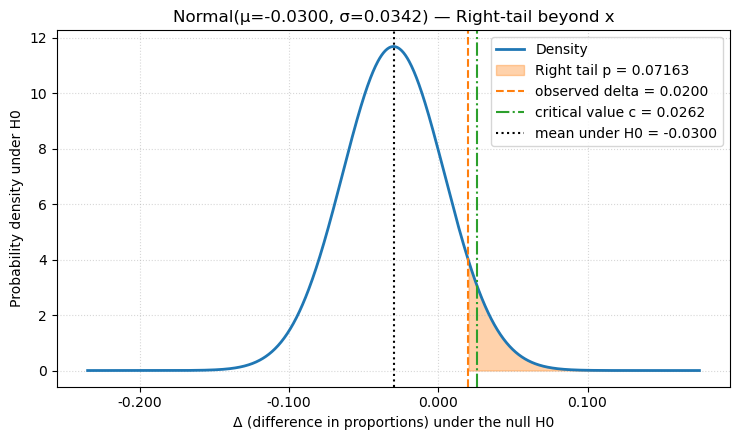

In [48]:
# Plot the Gaussian N(mu, sigma) and shade the right-tail area beyond x

# Use previously defined values; recompute to be robust
SE_H0 = wald_unpooled_SE
mu_H0 = -epsilon
sigma_HO = SE_H0
x0 = hatDelta_observed

# Domain for plotting (±6σ around the mean, clipped to reasonable bounds)
left = mu_H0 - 6 * sigma_HO
right = mu_H0 + 6 * sigma_HO
xs = np.linspace(left, right, 1000)
pdf = norm.pdf(xs, loc=mu_H0, scale=sigma_HO)

# Right-tail probabilityy
p = norm.sf(x0, loc=mu_H0, scale=sigma_HO)

# Critical value at significance alpha (one-sided)
crit_x = norm.ppf(1 - alpha, loc=mu_H0, scale=sigma_HO)

# Plot
fig, ax = plt.subplots(figsize=(7.5, 4.5))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.plot(xs, pdf, color="C0", lw=2, label="Density")

# Shade right tail
mask = xs >= x0
ax.fill_between(xs[mask], pdf[mask], color="C1", alpha=0.35, label=f"Right tail p = {p:.4g}")

# Vertical line at observed x
ax.axvline(x0, color="C1", ls="--", lw=1.5, label=f"observed delta = {x0:.4f}")

# Vertical line at critical value
ax.axvline(crit_x, color="C2", ls="-.", lw=1.5, label=f"critical value c = {crit_x:.4f}")

# Vertical line at the mean for the null hypothesis H0
ax.axvline(-epsilon, color="k", ls=":", lw=1.5, label=f"mean under H0 = {-epsilon:.4f}")

# Decorations
ax.set_title(f"Normal(μ={mu_H0:.4f}, σ={sigma_HO:.4f}) — Right-tail beyond x")
ax.set_xlabel("Δ (difference in proportions) under the null H0")
ax.set_ylabel("Probability density under H0")
ax.legend(loc="best")
ax.grid(True, ls=":", alpha=0.5)
plt.tight_layout()
# plt.show(), display handled by notebook



#### Traditional Presentation Using *z*-Scores

Another common way to compute the p-value in NHST is to **standardize** the observed statistic rather than work directly with $\hat{\Delta}_{\mathrm{obs}}$.

The idea:

- Convert our Gaussian with mean $\mu$ and standard deviation $\sigma$ into a **standard normal** $N(0,1)$.
- This is done by the familiar **$z$-score transformation**:

$$
Z = \frac{X - \mu}{\sigma}.
$$

For our non-inferiority test:

$$
Z_{\mathrm{NI}}
= \frac{\hat{\Delta} - E[\Delta]_{H_{\text{boundary}}}}{SE}
= \frac{\hat{\Delta} - (-\epsilon)}{SE}
= \frac{\hat{\Delta} + \epsilon}{SE}.
$$

Thus $Z_{\mathrm{NI}}$ follows approximately a standard normal $N(0,1)$ under $H_0$.

---

##### Tail Probability in Standard Normal Form

We want the probability (under $H_0$) of observing something at least as extreme as our sample:

$$
P\big[\hat{\Delta} \ge \hat{\Delta}_{\mathrm{obs}}\big]
= P\!\left[\frac{\hat{\Delta} + \epsilon}{SE}
       \ge \frac{\hat{\Delta}_{\mathrm{obs}}+\epsilon}{SE}\right].
$$

This is simply the **right-tail** probability of a standard normal:

$$
\int_{Z_{\mathrm{NI}}}^{+\infty} 
\frac{1}{\sqrt{2\pi}}\,e^{-z^2/2}\,dz.
$$

Using the standard normal survival function gives the same p-value as before — this is just the “classical” z-score framing that many NHST tutorials use.


In [49]:
zni = (hatDelta_observed + epsilon) / SE_H0
p_zni = norm.sf(zni)
print(f"z_NI: {zni:.4f}, p-value: {p_zni:.4f}")

z_NI: 1.4637, p-value: 0.0716


#### False Positive (Type I Error)

In this NHST setup, the **p-value** also represents the **probability of a false positive** —  
the chance of **rejecting the null hypothesis** (concluding “no unacceptable degradation”)  
when in fact there **is** a degradation.

By setting the significance level $\alpha = 0.05$, we accept a **5% risk** of making this wrong decision.


#### Probability of False Negative (Type II Error), Power, and Sample Size

The complement of the false positive (Type I) error is the **false negative** —  
failing to reject $H_0$ when the alternative $H_1$ is actually true.

In the context of a **non-inferiority test**, a false negative means:

> We fail the test (do **not** reject $H_0$) even though the new UX is truly **non-inferior** (as good or better than the old one).

---

##### Choosing an Effect Size Under $H_1$

Just as with the Type I error calculation, we need to pick an expected value for the difference $\Delta$ — but this time **under $H_1$**.

- In practice, we must choose a **single reference value** to center the alternative distribution.  
- A common (and pragmatic) choice is the **minimum effect size we care to detect** — often set to $E[\Delta] = 0$ (meaning *no difference* between variant and control).  
  - If the variant is truly “no worse” (Δ = 0), the test should reject $H_0$ most of the time.

This choice is somewhat **arbitrary** and reflects a **business decision**:  
“How small of a difference do we consider acceptable to detect?”

---

##### Modeling Under $H_1$

If we assume the variant is truly **no worse** (Δ = 0), we can pool samples to estimate the standard error (since under $H_1$ we’re treating them as coming from the same distribution):

$$
SE_{H_1}
= \text{WaldPooled SE}
= \sqrt{\hat{p}_{\mathrm{pool}}
(1-\hat{p}_{\mathrm{pool}})
\left(\tfrac{1}{n_C}+\tfrac{1}{n_A}\right)}.
$$

We then compare this **alternative distribution** (mean = 0, std = $SE_{H_1}$) to the **critical value** $c$ that was already set by the significance level $\alpha$.

---

##### Beta and Power

- **$\beta$ (Type II error)** = probability that the observed statistic falls **below the critical value** when the true mean is the one we chose under $H_1$ (e.g., Δ = 0).  
- **Power** = $1-\beta$ = probability of **correctly rejecting** $H_0$ when the variant is truly non-inferior.

Graphically:  
- The null distribution is centered at $-\epsilon$ (our boundary).  
- The alternative distribution is centered at $0$ (no degradation).  
- $\beta$ is the area of the alternative distribution **to the left of the critical value**.

---

##### Designing for Target Power

If we want to achieve a **target power** — commonly 80% (so $\beta = 0.2$) —  
we can **solve for the required sample size** (embedded in $SE$).

- Larger $n$ → smaller $SE$ → distributions separate more clearly → higher power.
- This is the usual **sample size calculation** step when planning an A/B test.

In practice, one:
1. Fixes $\alpha$ (e.g., 0.05).
2. Chooses the minimum effect size of interest (e.g., $\Delta=0$ for non-inferiority).
3. Sets desired power (e.g., 80%).
4. Solves for $n_C$ and $n_A$ to achieve that power given the pooled variance.


In [50]:
SE_H1 = wald_pooled_SE
mu_H1 = 0
sigma_H1 = SE_H1
x = critical_value
beta = norm.cdf(x, loc=mu_H1, scale=sigma_H1)
print(f"probabilityy of false negative a.k.a β a.k.a type 2 errors,  at critical value : {beta:.4f}")
power = 1 - beta
print(f"Power (1 - β): {power:.4f}")


probabilityy of false negative a.k.a β a.k.a type 2 errors,  at critical value : 0.7860
Power (1 - β): 0.2140


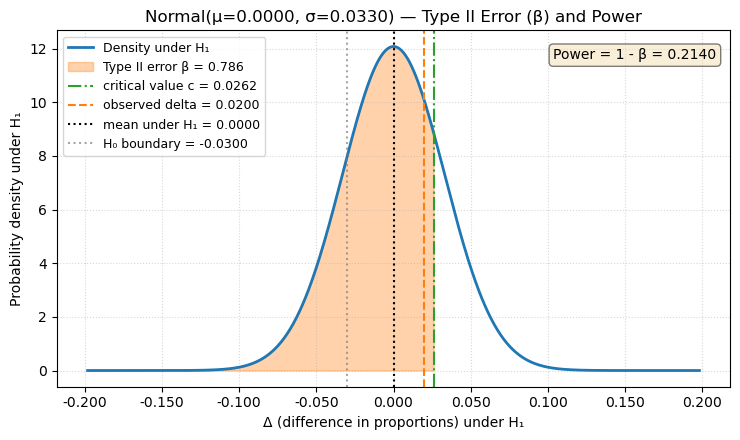

In [51]:
# Domain for plotting (±6σ around the mean, clipped to reasonable bounds)
left = mu_H1 - 6 * sigma_H1
right = mu_H1 + 6 * sigma_H1
xs = np.linspace(left, right, 1000)
pdf = norm.pdf(xs, loc=mu_H1, scale=sigma_H1)

# Plot
fig, ax = plt.subplots(figsize=(7.5, 4.5))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.plot(xs, pdf, color="C0", lw=2, label="Density under H₁")

# Shade left tail (Type II error region)
mask = xs <= critical_value
ax.fill_between(xs[mask], pdf[mask], color="C1", alpha=0.35, 
                label=f"Type II error β = {beta:.4g}")

# Vertical line at critical value
ax.axvline(critical_value, color="C2", ls="-.", lw=1.5, 
           label=f"critical value c = {critical_value:.4f}")

# Vertical line at observed delta
ax.axvline(hatDelta_observed, color="C1", ls="--", lw=1.5, 
           label=f"observed delta = {hatDelta_observed:.4f}")

# Vertical line at the mean under H1
ax.axvline(mu_H1, color="k", ls=":", lw=1.5, 
           label=f"mean under H₁ = {mu_H1:.4f}")

# Vertical line at the H0 boundary (for reference)
ax.axvline(-epsilon, color="gray", ls=":", lw=1.5, alpha=0.7,
           label=f"H₀ boundary = {-epsilon:.4f}")

# Decorations
ax.set_title(f"Normal(μ={mu_H1:.4f}, σ={sigma_H1:.4f}) — Type II Error (β) and Power")
ax.set_xlabel("Δ (difference in proportions) under H₁")
ax.set_ylabel("Probability density under H₁")
ax.legend(loc="best", fontsize=9)
ax.grid(True, ls=":", alpha=0.5)

# Add text annotation for power
power_text = f"Power = 1 - β = {power:.4f}"
ax.text(0.98, 0.95, power_text, transform=ax.transAxes, 
        fontsize=10, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()

### Bayesian Approach

In contrast to NHST, the **Bayesian approach** is conceptually simpler:

- Instead of fixing two specific expected values for $\Delta$ (one under $H_0$ and one under $H_1$),
- We treat the **true conversion difference** $E[\Delta]$ itself as an **unknown random variable** and reason about its entire probability distribution.

This lets us quantify directly how likely any value of $\Delta$ is, given both prior knowledge and the data we observe.

---

#### Using the Beta Distribution for Our Prior Belief

For experiments based on **Bernoulli trials** (success/failure, convert/abandon, etc.), the most convenient way to model our **prior belief** about a conversion rate is the **Beta distribution**.

> ⚠️ Don’t confuse this **Beta** with the “$\beta$” from NHST (Type II error).  
> Here, *Beta* is the name of a probability distribution.

The Beta distribution:

- Is defined on the interval $[0,1]$, making it perfect for modeling a **probability**.
- Has two shape parameters, $\alpha$ and $\beta$, which control how strongly it reflects our prior knowledge.

Some examples of possible priors:

- **Uninformative prior:** $ \mathrm{Beta}(1,1) $ — essentially a uniform distribution, expressing “we know nothing.”
- **Weakly informative prior:** centered roughly around 17–20% but wit


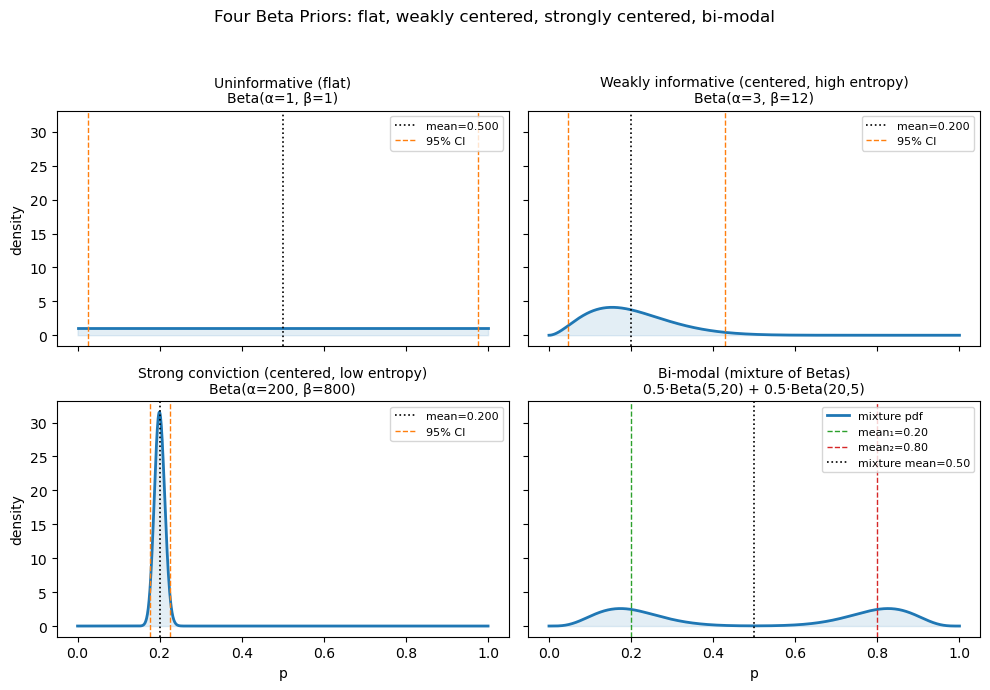

In [52]:
x = np.linspace(0, 1, 1000)

# Four cases:
cases = [
    ("Uninformative (flat)", ("single", (1, 1))),
    ("Weakly informative (centered, high entropy)", ("single", (3, 12))),   # mean=0.2
    ("Strong conviction (centered, low entropy)", ("single", (200, 800))),  # mean=0.2
    ("Bi-modal (mixture of Betas)", ("mixture", ((5, 20, 0.5), (20, 5, 0.5))))
]

fig, axes = plt.subplots(2, 2, figsize=(10, 7), sharex=True, sharey=True)

for ax, (title, (kind, params)) in zip(axes.ravel(), cases):
    if kind == "single":
        a, b = params
        y = beta_dist.pdf(x, a, b)
        mean = a / (a + b)
        ci_low, ci_high = beta_dist.ppf([0.025, 0.975], a, b)

        ax.plot(x, y, color="C0", lw=2)
        ax.fill_between(x, y, color="C0", alpha=0.12)
        ax.axvline(mean, color="k", ls=":", lw=1.2, label=f"mean={mean:.3f}")
        ax.axvline(ci_low, color="C1", ls="--", lw=1, label="95% CI")
        ax.axvline(ci_high, color="C1", ls="--", lw=1)
        ax.set_title(f"{title}\nBeta(α={a}, β={b})", fontsize=10)
        ax.legend(fontsize=8, loc="best")
    else:
        # Mixture of two Betas: (a1, b1, w1), (a2, b2, w2)
        (a1, b1, w1), (a2, b2, w2) = params
        y = w1 * beta_dist.pdf(x, a1, b1) + w2 * beta_dist.pdf(x, a2, b2)
        m1, m2 = a1 / (a1 + b1), a2 / (a2 + b2)
        mix_mean = w1 * m1 + w2 * m2

        ax.plot(x, y, color="C0", lw=2, label="mixture pdf")
        ax.fill_between(x, y, color="C0", alpha=0.12)
        # Component means
        ax.axvline(m1, color="C2", ls="--", lw=1, label=f"mean₁={m1:.2f}")
        ax.axvline(m2, color="C3", ls="--", lw=1, label=f"mean₂={m2:.2f}")
        # Mixture mean
        ax.axvline(mix_mean, color="k", ls=":", lw=1.2, label=f"mixture mean={mix_mean:.2f}")
        ax.set_title(f"{title}\n{w1:.1f}·Beta({a1},{b1}) + {w2:.1f}·Beta({a2},{b2})", fontsize=10)
        ax.legend(fontsize=8, loc="best")

for ax in axes[-1]:
    ax.set_xlabel("p")
for ax in axes[:, 0]:
    ax.set_ylabel("density")

fig.suptitle("Four Beta Priors: flat, weakly centered, strongly centered, bi-modal", fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.95])

#### Conservative Approach: Assuming We Know Nothing (Non-Informative Prior)

For the **variant A**, suppose we start with a **non-informative prior** — meaning we have no knowledge about the conversion rate $p_A$.  
We assume $p_A$ could be anywhere between $0$ and $1$ with equal probability.  
This is modeled by the Beta distribution:

$$
\mathrm{Beta}(1,1)
$$

— which is just a **uniform prior** on $[0,1]$.

---

##### Posterior After Observing Data

After running the experiment with:

- $n_A$ = number of trials (users shown variant A),
- $x_A$ = number of successes (conversions),

the **posterior** distribution for $p_A$ — thanks to the conjugacy of the Beta with the Bernoulli likelihood — is:

$$
\mathrm{Beta}(x_A+1,\; n_A - x_A + 1).
$$

This follows directly from **Bayes’ theorem** and the properties of the Beta distribution.

---

##### Expected Value of the Posterior

For any $\mathrm{Beta}(\alpha,\beta)$ distrib


In [53]:
expected_value_posterior = (xA_observed + 1) / (nA + 2)
print(f"Expected value of posterior distribution for p_A: {expected_value_posterior:.4f}")

Expected value of posterior distribution for p_A: 0.2237


#### Credible Intervals and Visualizing Prior vs. Posterior

A **credible interval** answers: *“Given the data and our prior, what range of parameter values has (say) 95% posterior probability?”*  
We will use **equal-tailed** credible intervals (quantiles at 2.5% and 97.5%).

For a Beta posterior on the variant’s conversion rate

$$
p_A \mid \text{data} \sim \mathrm{Beta}(\alpha_A,\beta_A),
$$

the \(100(1-\alpha)\%\) credible interval is

$$
\bigl[
\mathrm{Beta}^{-1}(\alpha/2;\,\alpha_A,\beta_A),\;
\mathrm{Beta}^{-1}(1-\alpha/2;\,\alpha_A,\beta_A)
\bigr].
$$

- **Prior** (uninformative): $\mathrm{Beta}(1,1)$  
- **Posterior** after observing $x_A$ conversions out of $n_A$:  
  $\alpha_A = x_A+1,\; \beta_A = n_A - x_A + 1$

We can compute these intervals and plot how the **posterior** updates our belief compared with the **prior**.


In [54]:
# Posterior parameters
alpha = xA_observed + 1
beta_param = nA - xA_observed + 1

# Ensure we use the beta distribution from scipy.stats
from scipy.stats import beta as beta_dist

# Compute 95% credible interval (2.5th and 97.5th percentiles)
p_L = beta_dist.ppf(0.025, alpha, beta_param)
p_U = beta_dist.ppf(0.975, alpha, beta_param)

# Output the result
print(f"95% Credible Interval for p: [{p_L:.4f}, {p_U:.4f}]")

95% Credible Interval for p: [0.1613, 0.2930]


In [55]:
# compute the 99% credible interval (1th and 99th percentiles)
p_L_99 = beta_dist.ppf(0.005, alpha, beta_param)
p_U_99 = beta_dist.ppf(0.995, alpha, beta_param)
# Output the result
print(f"99% Credible Interval for p: [{p_L_99:.4f}, {p_U_99:.4f}]")


99% Credible Interval for p: [0.1442, 0.3167]


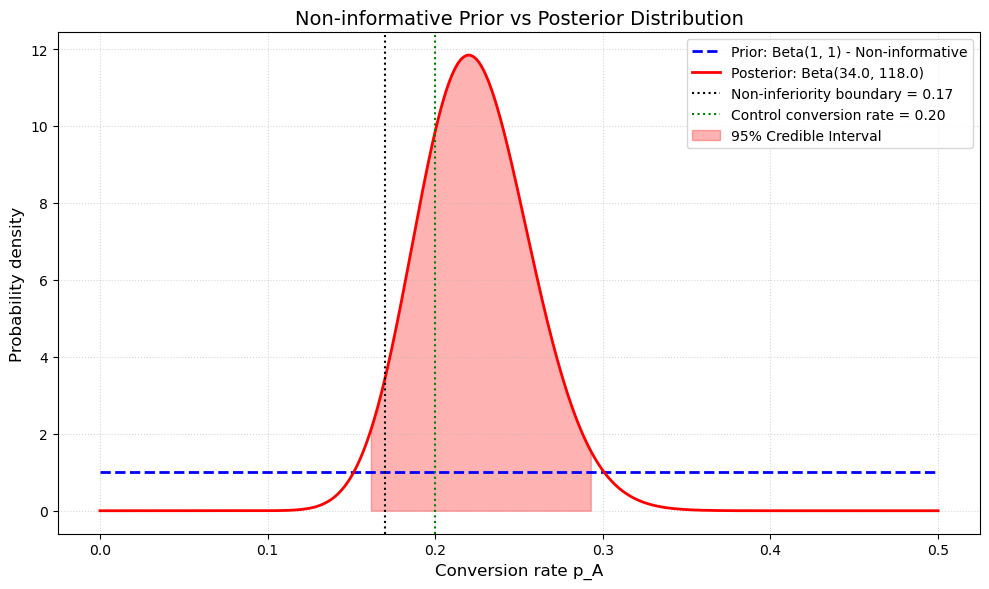

In [56]:
# Visualize non-informative prior vs posterior
x_range = np.linspace(0, 0.5, 1000)
prior_noninformative_pdf = beta_dist.pdf(x_range, 1, 1)  # Beta(1,1) - uniform
posterior_noninformative_pdf = beta_dist.pdf(x_range, alpha, beta_param)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x_range, prior_noninformative_pdf, 'b--', lw=2, label='Prior: Beta(1, 1) - Non-informative')
ax.plot(x_range, posterior_noninformative_pdf, 'r-', lw=2, label=f'Posterior: Beta({alpha:.1f}, {beta_param:.1f})')

# Mark the non-inferiority boundary
ax.axvline(control_group_conversion_rate - epsilon, color='k', ls=':', lw=1.5, 
           label=f'Non-inferiority boundary = {control_group_conversion_rate - epsilon:.2f}')

# Mark the control conversion rate
ax.axvline(control_group_conversion_rate, color='g', ls=':', lw=1.5, 
           label=f'Control conversion rate = {control_group_conversion_rate:.2f}')

# Shade the 95% credible interval
mask = (x_range >= p_L) & (x_range <= p_U)
ax.fill_between(x_range[mask], posterior_noninformative_pdf[mask], alpha=0.3, color='red', 
                label='95% Credible Interval')

ax.set_xlabel('Conversion rate p_A', fontsize=12)
ax.set_ylabel('Probability density', fontsize=12)
ax.set_title('Non-informative Prior vs Posterior Distribution', fontsize=14)
ax.legend(loc='best')
ax.grid(True, ls=':', alpha=0.5)
plt.tight_layout()
plt.show()

In [57]:
# Compute probability that variant is non-inferior using non-informative prior
prob_non_inferior_noninformative = 1 - beta_dist.cdf(control_group_conversion_rate - epsilon, 
                                                       alpha, beta_param)
print(f"Probability that variant is non-inferior (non-informative prior): {prob_non_inferior_noninformative:.4f}")
print(f"This means there's a {prob_non_inferior_noninformative*100:.2f}% probability that the variant conversion rate is above {control_group_conversion_rate - epsilon:.2f}")

Probability that variant is non-inferior (non-informative prior): 0.9514
This means there's a 95.14% probability that the variant conversion rate is above 0.17


#### Weakly Informative Prior Using Historical Data

Instead of using a completely non-informative prior $\mathrm{Beta}(1,1)$, we can incorporate **historical knowledge**.

Suppose we know the **control group** conversion rate is about **0.20**, and we want to test for **non-inferiority** with a margin $\epsilon = 0.03$.

For the variant, we choose a prior **centered** at:

$$
0.20 - 0.03 = 0.17
$$

(the non-inferiority boundary), but we want this prior to have **high entropy** (wide uncertainty) so it does not dominate the data.  
A **Beta** distribution with a modest $\alpha$ and $\beta$ can be informative about the center while still uncertain.

For a $\mathrm{Beta}(\alpha,\beta)$ distribution:

$$
\mu = \frac{\alpha}{\alpha+\beta}
$$

- Smaller values of $\alpha$ and $\beta$ give a **wider** (more uncertain) prior.
- Values around 2–5 keep it **unimodal** but not too tight; $\alpha,\beta < 1$ would make it U-shaped.

Let’s pick $\alpha = 3$ and solve for $\beta$ so the mean is $0.17$:

$$
0.17 = \frac{3}{3+\beta}
\quad\Longrightarrow\quad
\beta = \frac{3}{0.17} - 3 \approx 14.65.
$$

So we use a prior $\mathrm{Beta}(3,14.65)$ — centered at $0.17$ but still fairly wide.

After observing data $(x_A, n_A)$ for the varian


In [58]:
# Informative prior parameters
target_prior_mean = control_group_conversion_rate - epsilon  # 0.17
alpha_prior = 3  # Small value for high entropy
beta_prior = (alpha_prior / target_prior_mean) - alpha_prior  # Solve for beta given mean

print(f"Prior: Beta({alpha_prior:.2f}, {beta_prior:.2f})")
print(f"Prior mean: {alpha_prior / (alpha_prior + beta_prior):.4f}")
print(f"Prior variance: {(alpha_prior * beta_prior) / ((alpha_prior + beta_prior)**2 * (alpha_prior + beta_prior + 1)):.6f}")

# Posterior parameters after observing data
alpha_posterior = xA_observed + alpha_prior
beta_posterior = (nA - xA_observed) + beta_prior

print(f"\nPosterior: Beta({alpha_posterior:.2f}, {beta_posterior:.2f})")
posterior_mean = alpha_posterior / (alpha_posterior + beta_posterior)
print(f"Posterior mean: {posterior_mean:.4f}")

# Compute 95% credible interval
p_L_informative = beta_dist.ppf(0.025, alpha_posterior, beta_posterior)
p_U_informative = beta_dist.ppf(0.975, alpha_posterior, beta_posterior)
print(f"95% Credible Interval: [{p_L_informative:.4f}, {p_U_informative:.4f}]")

# Compute 99% credible interval
p_L_99_informative = beta_dist.ppf(0.005, alpha_posterior, beta_posterior)
p_U_99_informative = beta_dist.ppf(0.995, alpha_posterior, beta_posterior)
print(f"99% Credible Interval: [{p_L_99_informative:.4f}, {p_U_99_informative:.4f}]")

Prior: Beta(3.00, 14.65)
Prior mean: 0.1700
Prior variance: 0.007567

Posterior: Beta(36.00, 131.65)
Posterior mean: 0.2147
95% Credible Interval: [0.1561, 0.2798]
99% Credible Interval: [0.1401, 0.3021]


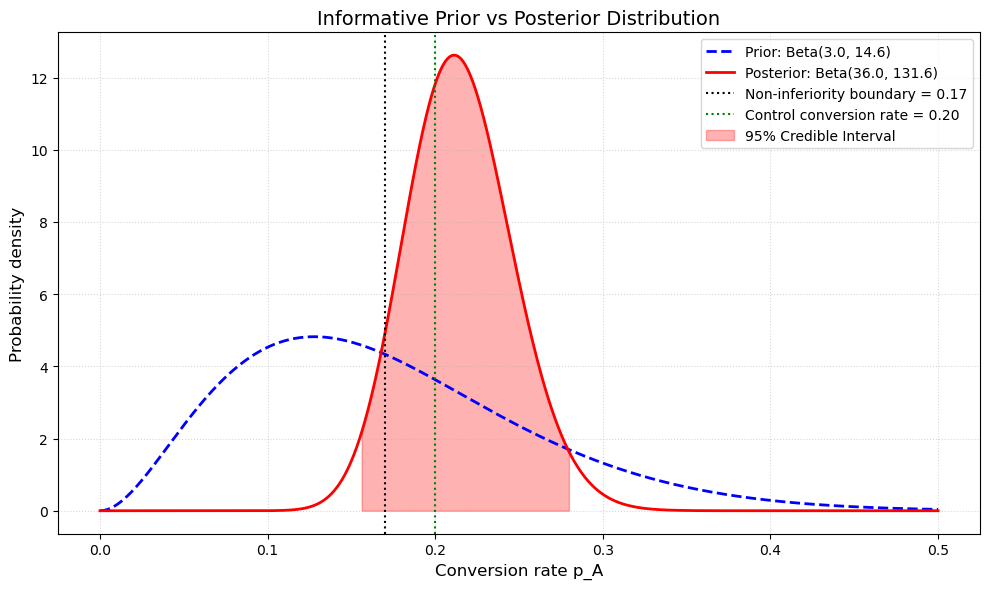

In [59]:
# Visualize prior vs posterior
x_range = np.linspace(0, 0.5, 1000)
prior_pdf = beta_dist.pdf(x_range, alpha_prior, beta_prior)
posterior_pdf = beta_dist.pdf(x_range, alpha_posterior, beta_posterior)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x_range, prior_pdf, 'b--', lw=2, label=f'Prior: Beta({alpha_prior:.1f}, {beta_prior:.1f})')
ax.plot(x_range, posterior_pdf, 'r-', lw=2, label=f'Posterior: Beta({alpha_posterior:.1f}, {beta_posterior:.1f})')

# Mark the non-inferiority boundary
ax.axvline(control_group_conversion_rate - epsilon, color='k', ls=':', lw=1.5, 
           label=f'Non-inferiority boundary = {control_group_conversion_rate - epsilon:.2f}')

# Mark the control conversion rate
ax.axvline(control_group_conversion_rate, color='g', ls=':', lw=1.5, 
           label=f'Control conversion rate = {control_group_conversion_rate:.2f}')

# Shade the 95% credible interval
mask = (x_range >= p_L_informative) & (x_range <= p_U_informative)
ax.fill_between(x_range[mask], posterior_pdf[mask], alpha=0.3, color='red', 
                label='95% Credible Interval')

ax.set_xlabel('Conversion rate p_A', fontsize=12)
ax.set_ylabel('Probability density', fontsize=12)
ax.set_title('Informative Prior vs Posterior Distribution', fontsize=14)
ax.legend(loc='best')
ax.grid(True, ls=':', alpha=0.5)
plt.tight_layout()
plt.show()

In [60]:
# Compute probabilityy that variant is non-inferior (p_A > p_C - epsilon)
# This is P(p_A > 0.17) under the posterior
prob_non_inferior = 1 - beta_dist.cdf(control_group_conversion_rate - epsilon, 
                                       alpha_posterior, beta_posterior)
print(f"Probability that variant is non-inferior: {prob_non_inferior:.4f}")
print(f"This means there's a {prob_non_inferior*100:.2f}% probabilityy that the variant conversion rate is above {control_group_conversion_rate - epsilon:.2f}")

Probability that variant is non-inferior: 0.9272
This means there's a 92.72% probabilityy that the variant conversion rate is above 0.17
